In [25]:
import pandas as pd
from sklearn.manifold import MDS
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import utils
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
from umap import UMAP
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler


In [26]:
D_data = pd.read_csv('data/Denmark/Merged.csv')

In [27]:
D_data

,Unnamed: 0,typeid_x,afstemningid,aktørid,party,dato
0,0,1,1,158,Socialistisk Folkeparti,2014-09-09T09:00:00
1,1,1,1,71,Det Konservative Folkeparti,2014-09-09T09:00:00
2,2,1,1,50,Uden for folketingsgrupperne,2014-09-09T09:00:00
3,3,1,1,49,Venstre,2014-09-09T09:00:00
4,4,1,1,183,Danmarksdemokraterne,2014-09-09T09:00:00
...,...,...,...,...,...,...
1026334,1026334,2,10145,130,Venstre,2025-03-18T13:00:00
1026335,1026335,2,10145,244,Socialdemokratiet,2025-03-18T13:00:00
1026336,1026336,2,10145,173,Venstre,2025-03-18T13:00:00
1026337,1026337,2,10145,80,Venstre,2025-03-18T13:00:00


In [28]:
D_data['dato'] = pd.to_datetime(D_data['dato'],errors='coerce')

start_date = "2019-06-01"
end_date = "2022-10-01"

D_data = D_data[(D_data['dato'] >= start_date) & (D_data['dato'] <= end_date)]

In [29]:
D_PA, D_PAV, D_PAVP, D_PP = utils.dict_create(D_data, 'aktørid','party','afstemningid','typeid_x')

In [30]:
# Step 1: Extract unique people (rows) and bills (columns)
people = list(D_PAV.keys())  # List of people
votes = set()  # Store the distinct votes/bills

for voted_bills in D_PAV.values():
    for bill, _ in voted_bills:
        votes.add(bill)

votes = sorted(votes)  # Sort bills to ensure consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in D_PAV.items():
    for bill, vote in voted_bills:  # Iterate over list of (bill, vote) pairs
        if vote == 1:
            value = 1  # Vote 1 → 0
        elif vote == 2:
            value = 2  # Vote 2 → 1
        else:
            continue  # Skip other votes

        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])  # Bill's column index
        data.append(value)  # Store transformed vote value

# Step 3: Create the sparse matrix (CSR format)
num_people_dk = len(D_PAV)  # Number of people
num_votes_dk = len(votes)  # Number of bills
sparse_matrix_dk = csr_matrix((data, (row_indices, col_indices)), shape=(num_people_dk, num_votes_dk))



In [31]:
sparse_matrix_dk.shape

(216, 1687)

In [32]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(sparse_matrix_dk)

node_to_community = {}
party_to_community = {
    'Alternativet': 0,  
    'Danmarksdemokraterne': 1,   
    'Dansk Folkeparti': 2,
    'Det Konservative Folkeparti': 3,
    'Enhedslisten': 4,
    'Frie Grønne': 5,
    'Liberal Alliance': 6,
    'Moderaterne': 7,
    'Radikale Venstre': 8,
    'Sambandsflokkurin': 9,
    'Siumut': 10,
    'Socialdemokratiet': 11,
    'Socialistisk Folkeparti': 12,
    'Uden for folketingsgrupperne': 13,
    'Venstre': 14,
     

}

# Color mapping
community_to_color = {
   0: 'green',
   1: 'lightblue', 
   2: 'yellow',
   3: 'darkgreen',
   4: 'orange',
   5: 'cyan',
   6: 'blue',
   7: 'magenta',
   8: 'purple',
   9: 'black',
   10: 'gray',
   11: 'red',
   12: 'pink',
   13: 'brown',
   14: 'navy'
}


person_to_party = {person: party for party, members in D_PP.items() for person in members}

In [33]:
def scale_to_unit_range(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(data)


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


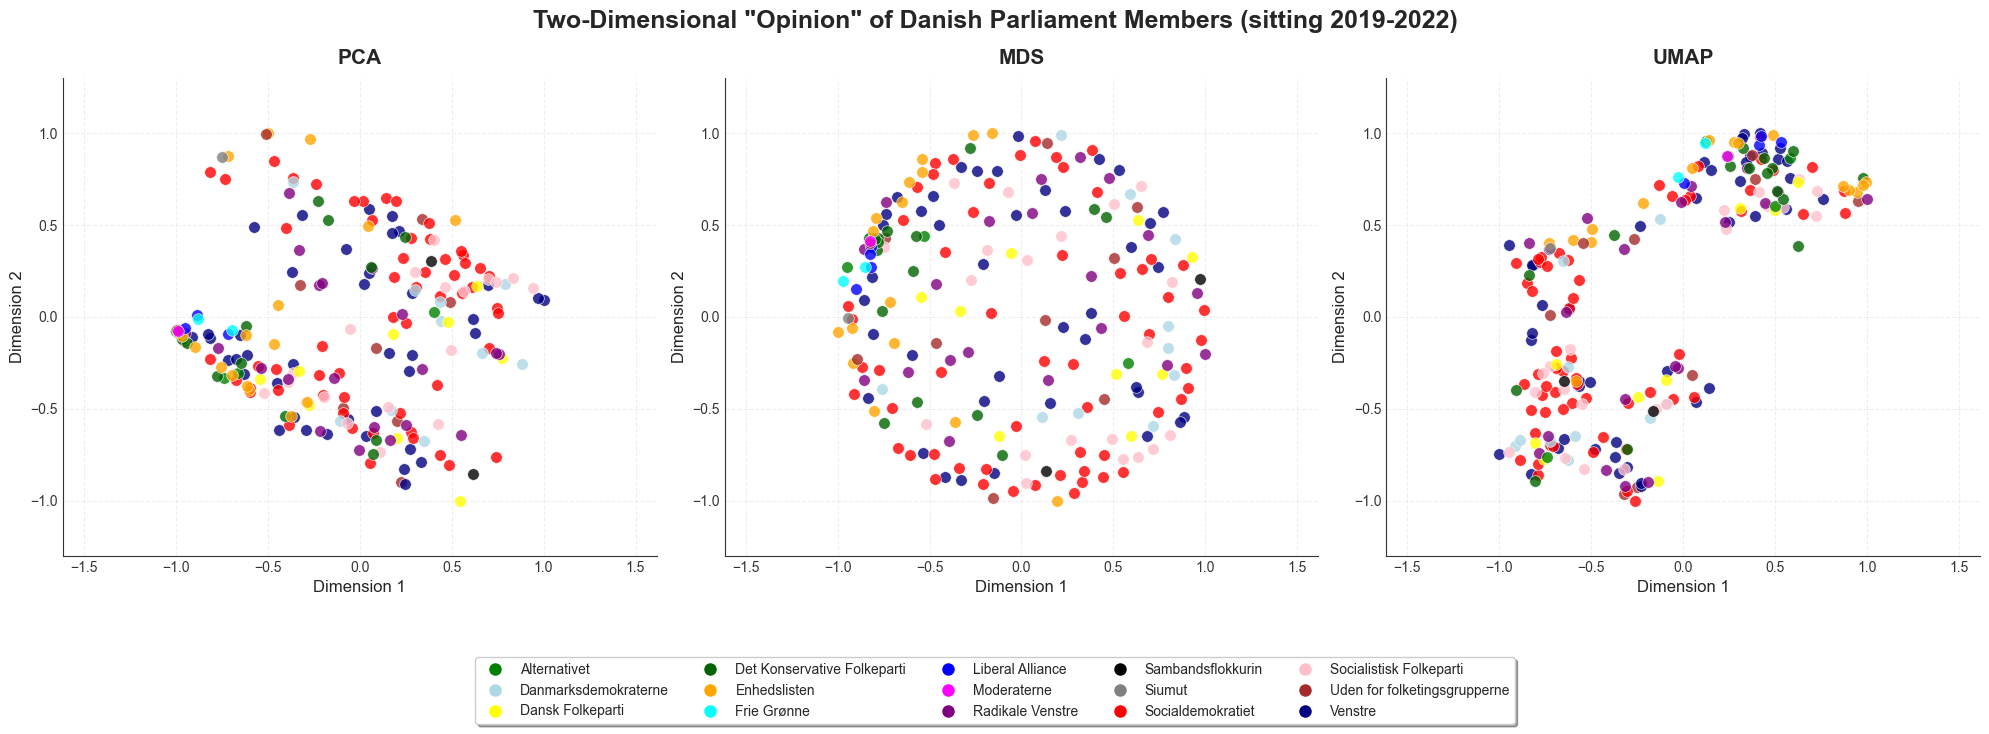

In [34]:
# Set the style for a professional look
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.color'] = '#333333'
mpl.rcParams['ytick.color'] = '#333333'

# Apply MDS and UMAP to the sparse matrix
n_components = 2

# Convert to dense array for processing if it's sparse
X_dense = sparse_matrix_dk.toarray() if hasattr(sparse_matrix_dk, 'toarray') else sparse_matrix_dk

# MDS transformation
# Since sparse_matrix_dk is not a square distance matrix, we'll compute distances first
mds = MDS(n_components=n_components, normalized_stress='auto')
mds_result = mds.fit_transform(sparse_matrix_dk.toarray())
mds_result = scale_to_unit_range(mds_result)

# UMAP transformation
umap_model = UMAP(n_components=n_components, metric='euclidean', min_dist=0.1)
umap_result = umap_model.fit_transform(sparse_matrix_dk.toarray())          
umap_result = scale_to_unit_range(umap_result)

# Get the PCA results (reuse from your existing code)
pca_result = pca.transform(sparse_matrix_dk.toarray())
pca_result = scale_to_unit_range(pca_result)
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Two-Dimensional "Opinion" of Danish Parliament Members (sitting 2019-2022)', fontsize=18, fontweight='bold', y=0.98)

# Get unique parties for consistent coloring
unique_parties = list(party_to_community.keys())
legend_elements = []

# Function to plot on a specific axis
def plot_embedding(embedding, ax, title):
    # Reset the handled parties for each plot
    plotted_parties = set()
    
    # Plot each point
    for i, point in enumerate(embedding):
        # Get the person
        person = list(person_to_party.keys())[i]  # Adjust as needed for your data structure
        
        # Get the party and color
        if person in person_to_party:
            party = person_to_party[person]
            community_id = party_to_community.get(party, 13)
            color = community_to_color[community_id]
            
            # Plot with a slightly larger marker size and higher alpha for better visibility
            ax.scatter(point[0], point[1], color=color, alpha=0.8, s=70, edgecolors='white', linewidth=0.5)
            
            # Track for legend (only once per party)
            if party not in plotted_parties:
                plotted_parties.add(party)
    
    # Add labels and title
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)
    ax.set_title(title, fontsize=15, fontweight='bold', pad=10)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid with alpha
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Equal aspect for better comparison
    ax.set_aspect('equal', 'datalim')

# Plot each embedding
plot_embedding(pca_result, axes[0], 'PCA')
plot_embedding(mds_result, axes[1], 'MDS')
plot_embedding(umap_result, axes[2], 'UMAP')

# Create a unified legend for all plots
legend_elements = []
for party, community_id in party_to_community.items():
    color = community_to_color[community_id]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                                 markersize=10, label=party))

# Place the legend below the plots
fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05),
           frameon=True, fancybox=True, shadow=True, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend at the bottom

# Show the plot
plt.savefig('danish_parliament_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()